In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
from netCDF4 import num2date
import numpy as np
import scipy.ndimage as ndimage
from siphon.ncss import NCSS

/Users/jungeunl/miniconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/jungeunl/miniconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Set up access to the data

In [15]:
# Create NCSS object to access the NetcdfSubset
base_url = 'https://www.ncei.noaa.gov/thredds/ncss/grid/gfs-g4-anl-files/'
dt = datetime(2016, 8, 22, 18)
ncss = NCSS('{}{dt:%Y%m}/{dt:%Y%m%d}/gfsanl_4_{dt:%Y%m%d}_'
            '{dt:%H}00_003.grb2'.format(base_url, dt=dt))

#base_url = 'https://www.ncei.noaa.gov/thredds/ncss/grid/gfs-g4-anl-files/'
#dt = datetime(2017, 4, 5, 12)
#ncss = NCSS('{}{dt:%Y%m}/{dt:%Y%m%d}/gfsanl_4_{dt:%Y%m%d}_'
#            '{dt:%H}00_003.grb2'.format(base_url, dt=dt))

# Create lat/lon box for location you want to get data for
query = ncss.query()
query.lonlat_box(north=50, south=30, east=-80, west=-115)
query.time(datetime(2016, 8, 22, 21))

# Request data for geopotential height
query.variables('Geopotential_height_isobaric', 'u-component_of_wind_isobaric',
                'v-component_of_wind_isobaric')

var=u-component_of_wind_isobaric&var=v-component_of_wind_isobaric&var=Geopotential_height_isobaric&time=2016-08-22T21%3A00%3A00&west=-115&east=-80&south=30&north=50

Choose a height

In [16]:
query.vertical_level(100000)  # 1000 hPa

var=u-component_of_wind_isobaric&var=v-component_of_wind_isobaric&var=Geopotential_height_isobaric&time=2016-08-22T21%3A00%3A00&west=-115&east=-80&south=30&north=50&vertCoord=100000

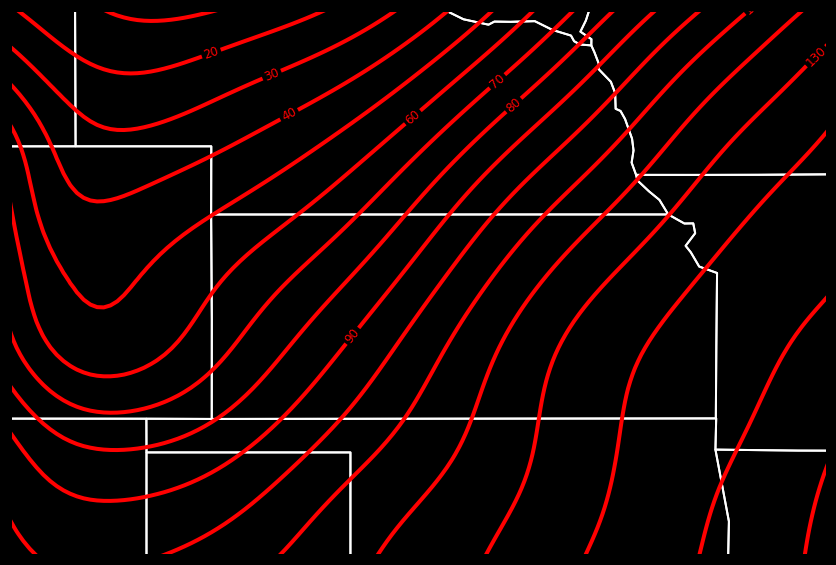

In [19]:
data = ncss.get_data(query)

# Pull out variables you want to use
height_var = data.variables['Geopotential_height_isobaric']
u_wind_var = data.variables['u-component_of_wind_isobaric']
v_wind_var = data.variables['v-component_of_wind_isobaric']

# Find the name of the time coordinate
for name in height_var.coordinates.split():
    if name.startswith('time'):
        time_var_name = name
        break
time_var = data.variables[time_var_name]

lat_var = data.variables['lat']
lon_var = data.variables['lon']

# Get actual data values and remove any size 1 dimensions
lat = lat_var[:].squeeze()
lon = lon_var[:].squeeze()
height = height_var[0, 0, :, :].squeeze()
u_wind = u_wind_var[0, 0, :, :].squeeze() * units('m/s')
v_wind = v_wind_var[0, 0, :, :].squeeze() * units('m/s')

# Convert number of hours since the reference time into an actual date
time = num2date(time_var[:].squeeze(), time_var.units)

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Smooth height data
height = ndimage.gaussian_filter(height, sigma=1.5, order=0)

# Set up some constants based on our projection, including the Coriolis parameter and
# grid spacing, converting lon/lat spacing to Cartesian
f = mpcalc.coriolis_parameter(np.deg2rad(lat_2d)).to('1/s')
dx, dy = mpcalc.lat_lon_grid_deltas(lon_2d, lat_2d)

# In MetPy 0.5, geostrophic_wind() assumes the order of the dimensions is (X, Y),
# so we need to transpose from the input data, which are ordered lat (y), lon (x).
# Once we get the components,transpose again so they match our original data.
geo_wind_u, geo_wind_v = mpcalc.geostrophic_wind(height * units.m, f, dx, dy)
geo_wind_u = geo_wind_u
geo_wind_v = geo_wind_v

# Calculate ageostrophic wind components
ageo_wind_u = u_wind - geo_wind_u
ageo_wind_v = v_wind - geo_wind_v

# Create new figure
fig = plt.figure(figsize=(15, 10), facecolor='black')

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-105., -93., 35., 43.])
ax.background_patch.set_fill(False)

# Add state boundaries to plot
ax.add_feature(cfeature.STATES, edgecolor='white', linewidth=2)

# Contour the heights every 10 m
contours = np.arange(10, 200, 10)
# Because we have a very local graphics area, the contours have joints
# to smooth those out we can use `ndimage.zoom`
zoom_500 = ndimage.zoom(height, 5)
zlon = ndimage.zoom(lon_2d, 5)
zlat = ndimage.zoom(lat_2d, 5)
c = ax.contour(zlon, zlat, zoom_500, levels=contours,
               colors='red', linewidths=4)
ax.clabel(c, fontsize=12, inline=1, inline_spacing=3, fmt='%i')

# Set up parameters for quiver plot. The slices below are used to subset the data (here
# taking every 4th point in x and y). The quiver_kwargs are parameters to control the
# appearance of the quiver so that they stay consistent between the calls.
quiver_slices = (slice(None, None, 2), slice(None, None, 2))
quiver_kwargs = {'headlength': 4, 'headwidth': 3, 'angles': 'uv', 'scale_units': 'xy',
                 'scale': 20}

geo = ax.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                geo_wind_u[quiver_slices], geo_wind_v[quiver_slices],
                color='darkorchid', **quiver_kwargs)
ageo = ax.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                 ageo_wind_u[quiver_slices], ageo_wind_v[quiver_slices],
                 color='lime', **quiver_kwargs)

# Add a title to the plot
plt.title('1000mb Geopotential Heights(m), Wind(blue), Geostrophic Wind(purple), and \n'
          'Ageostrophic Wind(green) for {0:%d %B %Y %H:%MZ}'.format(time),
          color='white', size=14)



In [20]:
# Plot the wind vectors
wind = ax.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                 u_wind[quiver_slices], v_wind[quiver_slices],
                 color='blue', **quiver_kwargs)

### Exercise 
Choose 500 hPa and do make a similar plot.